# Report 
ACSE-3 Course Work 1

Richard Boyne

Due 24th Nov 2018

In [1]:
# module importing
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpltools.annotation import slope_marker

# import my solution code
from solutions import RK2_alpha, Euler_Forwards, Euler_Improved, simple_taylor, partial_taylor
from solutions import Trapezodial, Euler_Backward, RK4_alpha, AM3_PC, AB4

# matplotlib settings
plt.rc('axes', titlesize=20, labelsize=20)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('lines', linewidth=1.5, markersize=7)
plt.rc('figure', figsize=[9, 9])
plt.rc('legend', fontsize=15)

## Task 1A - Implementing the RK2 family of methods

Here we are asked to implement and analyze an Rk2 solver.

\begin{align*}
k_1 & = f(t_n, y_n)\;dt, \\[5pt] 
k_2 & = f(t_n + \alpha \; dt, y_{n})\;dt + \alpha \; k_1, \\[5pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right) k_1 +  \frac{1}{2\alpha} k_2
\end{align*}

For this task we consider the following example problem:

$$ y' = y + t^3, \;\;\;\;\;\; y(0) = 1, $$  

which has the exact solution

$$ y(t) = 7\text{e}^t - t^3 - 3t^2 - 6t - 6. $$

### Create the solver

The RK2 solver function is found in solutions.py. It (as well as all other integrating functions written for this report) take input of (f, y0, t0, t_max, dt) where f(t, y) is the derivative function to solve from initial conditions y0 at t0 up to a time of $t_{max}$ with step size dt. It validates input parameters to ensure f is a function, y0 is indexable (even for a single variable problem it must make an array with a definite shape) and the others are in float format. For the case of RK2 an optional alpha parameter is passed with the default of $\alpha=0.5$ as is standard for the RK2 method. 

With the choice α=1 my implementation should be the same as the improved (predicator-corrector) Euler method also implemented here, following the equation as seen in lecture 5.

average difference =  1.0237424942859339e-14


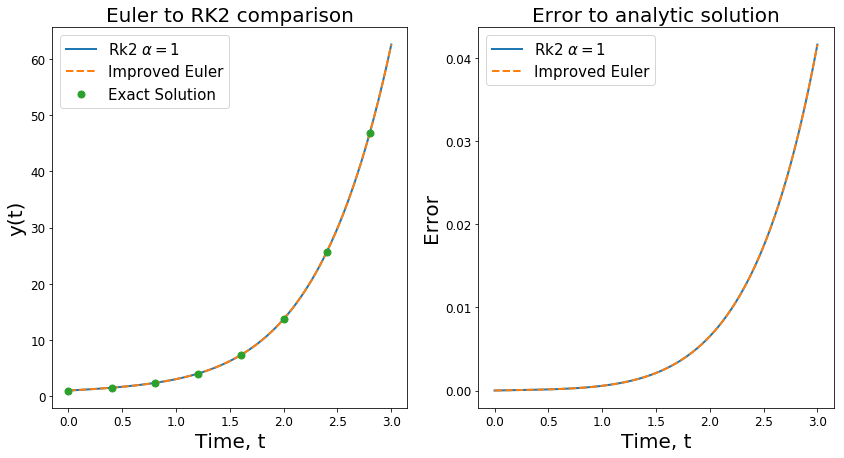

In [2]:
# test different alpha values

# equations to solve
def func1(t, y):
    return y + t**3
def func1_exact(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6

# set up
y0, dt, t0, t_max = [1.], 0.04, 0., 3.
fig, ax = plt.subplots(1, 2, figsize=[14,7])

# solve with alpha=1
time1, sol1 = RK2_alpha(func1, y0, t0, t_max, dt, alpha=1.)
time2, sol2 = Euler_Improved(func1, y0, t0, t_max, dt)
exact = func1_exact(time1)  # all time arrays are the same here

# plot solutions
ax[0].plot(time1, sol1, '-', label=r'Rk2 $\alpha=1$', lw=2)
ax[0].plot(time1, sol2, '--', label=r'Improved Euler', lw=2)
ax[0].plot(time1[::10], exact[::10], 'o', label=r'Exact Solution')

# plot errors
ax[1].plot(time1, abs(exact-sol1.flatten()), '-', label=r'Rk2 $\alpha=1$', lw=2)
ax[1].plot(time2, abs(exact-sol2.flatten()), '--', label=r'Improved Euler', lw=2)

# clean up figures
ax[0].legend()
ax[1].legend()
ax[0].set(title=r'Euler to RK2 comparison', xlabel='Time, t', ylabel='y(t)')
ax[1].set(title='Error to analytic solution', xlabel='Time, t', ylabel='Error')

# workout the average difference
diff = abs(sol1 - sol2).mean()
print('average difference = ', diff)

As can be seen the results are only different by $\sim 10^{-14}$, which is reasonable to assume is due to the truncation error of floating point numbers (i.e. machine precision).

### Order of Accuracy
By taking the difference between the exact solution at $t=3$ as our error metric we can find and compare the order of accuracy for these methods by using a range of $dt$ values. A separate implementation of forward Euler is compared here as well.

#### Final time evaluation problem
The time of solution evaluations in these method are always multiples of $dt$. This means that $t_{max}$ is not explicitly evaluated, and instead some point less than $dt$ after is the final solution evaluation. This causes issue for finding the requested error metric, there are three solutions I have thought of:

1) Implement some kind of interpolation between the penultimate and final points, then use this to evaluate the solution at $t_{max}$. To do this I created a function that linearly interpolates and correct the final value measured (not shown here, but found in solutions.py). Unfortunately as any interpolation, no matter how accurate, introduces its own error there is no telling whether the integrator or interpolation is dominant in the difference to the true solution, hence this method is not viable.

2) Choose a $dt$ such that $t_{max}$ is a multiple. As for the purpose of computing the accuracy we are free to choose our $dt$ values this seems the logical choice. The only issue arises when we have an irrational $t_{max}$ (see later), however this affect is not present here.

3) Make the assumption that error is a slowly changing function therefore: $Error(t_{max}) \approx Error(t_{max} + dt)$. Then we can find the error at the final time evaluated and use it for the error at $t_{max}$. This is good, but not perfect as you are not actually comparing errors at $t_{max}$ but near it, however this is the only reasonable way to compare for an arbitrary $dt$  value.

Here we use the 2nd method as it is the only one that gives the true error at $t_{max}$.

[1.98349029 1.55120122]


[Text(0,0.5,'y(t)'), Text(0.5,0,'dt'), Text(0.5,1,'RK2 Convergence')]

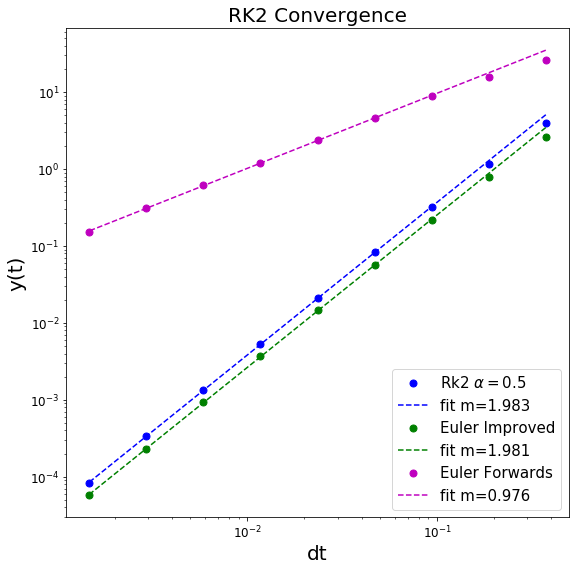

In [3]:
# compute order of accuracy for RK2

# setup
y0, t0, t_max = [1.], 0., 3.
n_values = np.array([2**n for n in range(3,12)])
dts = t_max / n_values
errors = np.zeros([dts.size, 3])
exact = func1_exact(t_max)

# solve for each dt
for n, dt in enumerate(dts):
    time1, sol1 = RK2_alpha(func1, y0, t0, t_max, dt, alpha=.5)
    time2, sol2 = Euler_Improved(func1, y0, t0, t_max, dt)
    time3, sol3 = Euler_Forwards(func1, y0, t0, t_max, dt)
    errors[n] = [abs(exact-sol1[-1]), abs(exact-sol2[-1]), abs(exact-sol3[-1])]

# fit a line in log space
log_err = np.log10(errors)
log_dts = np.log10(dts)
params1 = np.polyfit(log_dts[2:], log_err[2:, 0], deg=1)
params2 = np.polyfit(log_dts[2:], log_err[2:, 1], deg=1)
params3 = np.polyfit(log_dts[2:], log_err[2:, 2], deg=1)

print(params1)
# plot the results
fig, ax = plt.subplots(figsize=[9, 9])
de_log = lambda x, c0, c1 : 10**(x*c0 + c1)

ax.loglog(dts, errors[:, 0], 'bo', label=r'Rk2 $\alpha=0.5$')
ax.loglog(dts, de_log(log_dts, *params1), 'b--', label=r'fit m=%.3f' % params1[0])
ax.loglog(dts, errors[:, 1], 'go', label=r'Euler Improved')
ax.loglog(dts, de_log(log_dts, *params2), 'g--', label=r'fit m=%.3f' % params2[0])
ax.loglog(dts, errors[:, 2], 'mo', label=r'Euler Forwards')
ax.loglog(dts, de_log(log_dts, *params3), 'm--', label=r'fit m=%.3f' % params3[0])
ax.legend()
ax.set(title=r'RK2 Convergence', xlabel='dt', ylabel='y(t)')

As can be seen both RK2 and Improved Euler are $\mathcal{O}(dt^2)$ global error methods, so have second order rates of convergence, and should be able to solve polynomials up to quadratic exactly within machine precision (this means that f supplied is linear). Forwards Euler is found to be first order, all of which agrees with the known theory for these methods.

To find the error orders a linear fit is done in log space with the highest $dt$ values had to be excluded as they are seen to not follow the linear trend in log space. This is because higher order terms become more significant at larger $dt$ values making the method less accurate and not linear. For the same reason all the gradients in log space are just under the expected values (i.e. $0.976 < 1$) as the higher order terms along with machine precision make the errors slightly more and so the methods are slightly worse than the optimal values from theory.

### Analyze $\alpha$ convergence
The error to the analytical solution is dependent on the $\alpha$ value, to which the optimal value is different for to each specific problem. To show this several different values of $\alpha$ are used for error comparison. The error to the analytical solution is found at $t=3$ for a range of dt values to get a convergence plot for each $\alpha$ value.

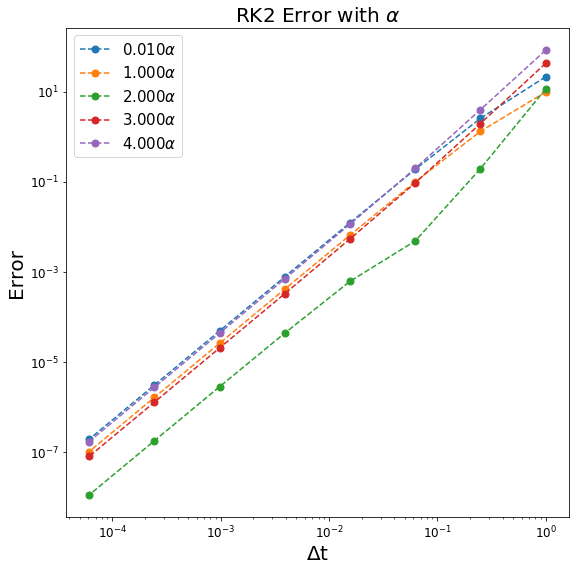

In [4]:
# error as a function of alpha

# set up
alphas = np.array([0.01, 1, 2, 3, 4])
dts = np.array([1/2**n for n in range(0, 15, 2)])
y0, t0, t_max = [1], 0., 3.
fig, ax = plt.subplots(figsize=[9, 9])

# solve and plot
for a in alphas:
    errors = []
    for dt in dts:
        time, sol = RK2_alpha(func1, y0, t0, t_max, dt, alpha=a)
        
        analytic = func1_exact(t=t_max)
        errors.append(abs(analytic - sol[-1]))
    ax.loglog(dts, errors, '--o', label=r'$%.3f \alpha$' % a)

ax.set(title=r'RK2 Error with $\alpha$',
       xlabel=r'$\Delta$t', ylabel='Error')
ax.legend()


So the error oder appears to be best for an alpha value around $\alpha=2$, however for large $dt$ values $\alpha=1$ is marginally better. A similar situation is seen for $\alpha=3$ and $\alpha=0.01$, which shows that the optimal alpha value depends on the choice of $dt$. As the dt could be interpreted as the resolution of the problem we are solving, and as we know optimal $\alpha$ depends on the problem it is logical that $dt$ is significant also.

If we fix $dt=0.01$ we can then use attempt to find the optimal $\alpha$ value:

[Text(0,0.5,'Error'),
 Text(0.5,0,'$\\alpha$'),
 Text(0.5,1,'Error dependence on $\\alpha$')]

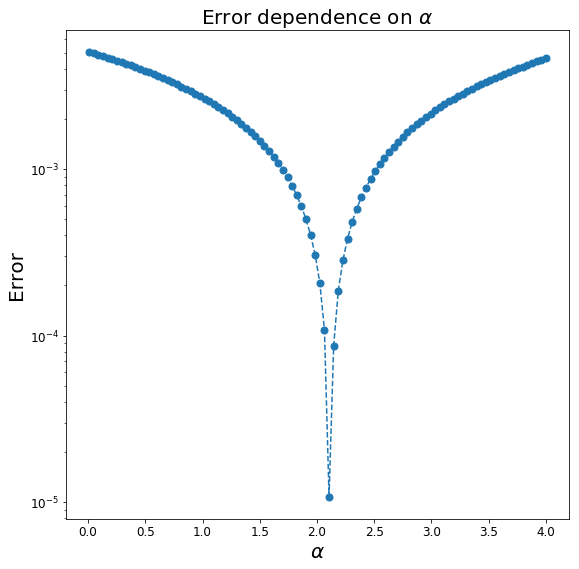

In [16]:
# observe optimal alpha value

# set up
alphas = np.linspace(0.01, 4, 100)
dt, y0, t0, t_max = 0.01, [1.], 0., 3.
errors = []
analytic = func1_exact(t=t_max)

# solve
for a in alphas:
    time, sol = RK2_alpha(func1, y0, t0, t_max, dt, alpha=a)
    errors.append(abs(analytic - sol[-1]))

# plot
fig, ax = plt.subplots(figsize=[9, 9])
ax.semilogy(alphas, errors, '--o')
ax.set(title=r'Error dependence on $\alpha$', xlabel=r'$\alpha$', ylabel='Error')

We can see this has an optimal value around $\alpha\approx2.1$. This can be more accurately computed using a minimize method (here I use scipy):

In [6]:
def to_minimse(alpha, dt, y0, t_max, analytic):
    time, sol = RK2_alpha(func1, y0, t0, t_max, dt, alpha=alpha)
    return abs(analytic - sol[-1])

dt, y0, t0, t_max = 0.01, [1], 0, 3
analytic = func1_exact(t=t_max)

import scipy.optimize as sci
init_guess = 2.1
opt = sci.minimize(to_minimse, init_guess, args=(dt, y0, t_max, analytic))
print(opt)

      fun: 5.4285465012071654e-12
 hess_inv: array([[2.46845824]])
      jac: array([0.00170422])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 276
      nit: 1
     njev: 88
   status: 2
  success: False
        x: array([2.11020269])


Ignoring whatever scipy is unhappy about, the optimal solution is close to what we initially guessed at $\alpha=2.110$ for this specific problem and $dt$ value. We can convince ourselves of this by sampling this region on a very fine resolution (varying from $2.1102025 < \alpha < 2.1102028$):

smallest on fine resolution = 2.110202693939394


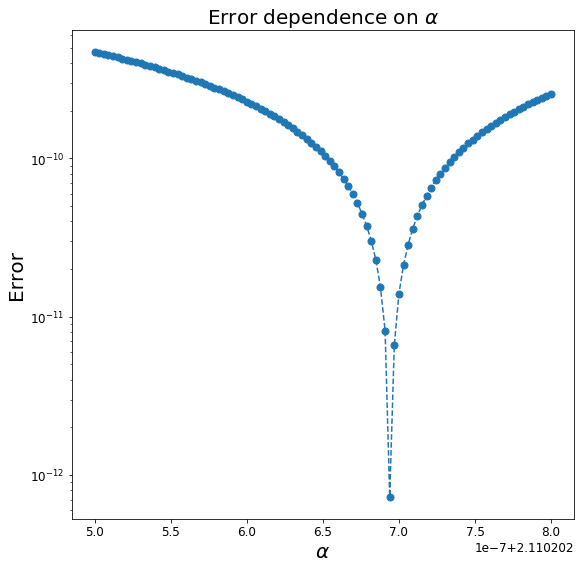

In [7]:
# zoomed in on significant area

# set up
alphas = np.linspace(2.1102025, 2.1102028, 100)
dt, y0, t0, t_max = 0.01, [1.], 0., 3.
errors = []
analytic = func1_exact(t=t_max)

# solve
for a in alphas:
    time, sol = RK2_alpha(func1, y0, t0, t_max, dt, alpha=a)
    errors.append(abs(analytic - sol[-1]))

# plot
fig, ax = plt.subplots(figsize=[9, 9])
ax.semilogy(alphas, errors, '--o')
ax.set(title=r'Error dependence on $\alpha$', xlabel=r'$\alpha$', ylabel='Error')

print('smallest on fine resolution =', alphas[np.argmin(errors)])

## Coursework 1B - Implementing Taylor series methods

Here we are inspecting the difference of taking a Taylor series to different truncation orders. As the general function we are integrating for is a function of both function of the current solution value y and the current time t, so we need to consider partial derivatives:

$$ f' = f_t + f \, f_y.  $$
$$ f'' = f_{tt} + 2f\,f_{yt} + f_t\,f_y + f\,f_y^2 + f^2\,f_{yy}. $$

To accommodate for both partial derivative and total derivate forms of user input I wrote two functions, one that takes total derivatives and another that takes partial derivatives forms given above, each returning values from Taylor truncations in the 2nd, 3rd and 4th order (i.e. so highest order terms of are 1st, 2nd and 3rd order in $dt$ respectively). Using the previous example problem the error at $t=2$ with a range of $dt$ values can be used to analyze the error orders for the different truncation orders.

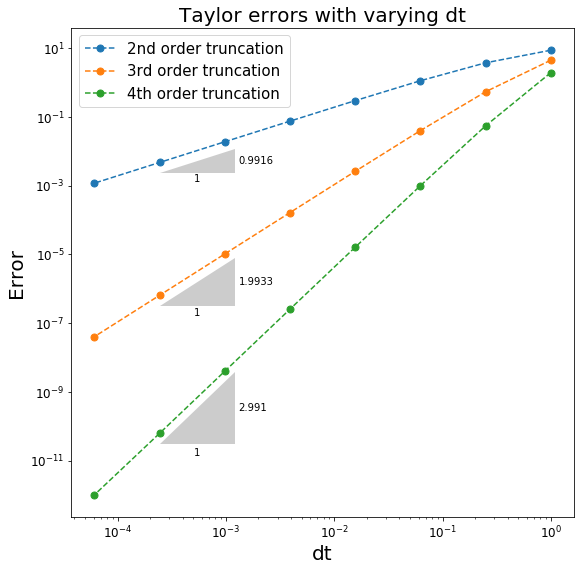

In [8]:
# solve with taylorseries

# partial derivatives
def func1_y(t, y):
    return 1
def func1_yy(t, y):
    return 0
def func1_t(t, y):
    return 3*t**2
def func1_tt(t, y):
    return 6*t
def func1_yt(t, y):
    return 0

# setup
y0, t_max, t0 = [1], 2, 0
dts = np.array([1/2**n for n in range(0, 15, 2)])
errors = np.zeros([dts.size, 3])
exact = func1_exact(t_max)
funcs = (func1, func1_y, func1_yy, func1_t, func1_tt, func1_yt)
                   
# solve
for n, dt in enumerate(dts):
    times, sol_0, sol_1, sol_2 = partial_taylor(*funcs, y0, t0, t_max, dt)
    errors[n] = [abs(exact - sol_0[-1]),
                 abs(exact - sol_1[-1]),
                 abs(exact - sol_2[-1])]

# fit error order lines
log_err = np.log10(errors[2:])
log_dts = np.log10(dts[2:])  # exclude the 2 largest dts from fitting
params_0 = np.polyfit(log_dts, log_err[:, 0], 1)
params_1 = np.polyfit(log_dts, log_err[:, 1], 1)
params_2 = np.polyfit(log_dts, log_err[:, 2], 1)

# plot
fig, ax = plt.subplots(figsize=[9, 9])
ax.loglog(dts, errors[:, 0], 'o--', label='2nd order truncation')
ax.loglog(dts, errors[:, 1], 'o--', label='3rd order truncation')
ax.loglog(dts, errors[:, 2], 'o--', label='4th order truncation')
slope_marker([dts[-2], errors[-2, 0]*0.5], [round(params_0[0], 4), 1], ax=ax, size_frac=0.15, pad_frac=0.05)
slope_marker([dts[-2], errors[-2, 1]*0.5], [round(params_1[0], 4), 1], ax=ax, size_frac=0.15, pad_frac=0.05)
slope_marker([dts[-2], errors[-2, 2]*0.5], [round(params_2[0], 4), 1], ax=ax, size_frac=0.15, pad_frac=0.05)
ax.set(title='Taylor errors with varying dt', xlabel='dt', ylabel='Error')
ax.legend()

The order lines have been fit as before and show the same trends with regard to always being just under the convergence order value and breaking the linear relationship for large $dt$.
It is seen that that the error order is always 1 less than the order of truncation, which makes sense as the error order is the same as the largest $dt$ order left in the Taylor series.

## Coursework 1C - Implementing the Adams-Moulton 3-step method (AM3)

Here we are asked to derive and confirm the parameters in the AM3 implicit method. In this we assume that a linear combination of previous derivatives can be used to better estimate the next solution value.

<img src="./figs/AM3_maths.jpg" width=900px>

To solve this matrix equation we can use Gaussian elimination:

In [9]:
# solve the system of linear equations by guassian elimination

A = np.array([[1, 1, 1, 1],
              [1, 0, -1, -2],
              [1, 0, 1, 4],
              [1, 0, -1, -8]])
b = np.array([[1, 1/2, 1/3, 1/4]]).T
x = np.zeros(b.size).T
aug = np.hstack([A, b]).astype(float)

# make the upper triangle matrix form
for i, row in enumerate(aug):
    row /= row[i]  # normalised the diagonal
    aug[i] = row
    for j in range(i+1, len(aug)):  # for j >= i
        aug[j] -= row * aug[j, i]

# backward subsitiution for x
for i in range(len(x))[::-1]:
    s = sum([aug[i, j] * x[j] for j in range(i, len(x))])
    x[i] = aug[i, -1] - s

# check solution
expexted = np.array([9, 19, -5, 1]) / 24
print('| %10s | %10s | %10s |\n' % ('alpha', 'calculated', 'expected'), '-' * 38)
for n in range(4):
    print('| %10s | %10s | %10s |' % ('n = ' + str(1-n), str(x[n])[:6], str(expexted[n])[:6]))
print('\nsum of differences to expected = ', abs(x - expexted).sum())

|      alpha | calculated |   expected |
 --------------------------------------
|      n = 1 |      0.375 |      0.375 |
|      n = 0 |     0.7916 |     0.7916 |
|     n = -1 |     -0.208 |     -0.208 |
|     n = -2 |     0.0416 |     0.0416 |

sum of differences to expected =  1.3877787807814457e-16


Note the alpha here is with respect to the notation used in the above derivation. The difference to the expected values is within machine truncation error, so we can be certain this is the correct derivation. For simplicity the fractional forms given will be used in the algorithm later.

### Implement AM3 Predictor - Corrector

Here we are asked to solve the following system with an implemented AM3_PC (predicator-corrector with AB4 as the initial guess), AB4 and RK4:

$$y'(t) = y,\;\;\; y(0)=1,$$

Each of the integrators was implemented by me (not using scipy), with both AB4 and AM3_PC using RK4 as a startup for the first 3 iterations.

[Text(105,0.5,'Error'),
 Text(0.5,75,'Time, t'),
 Text(0.5,1,'Error to analytic solution')]

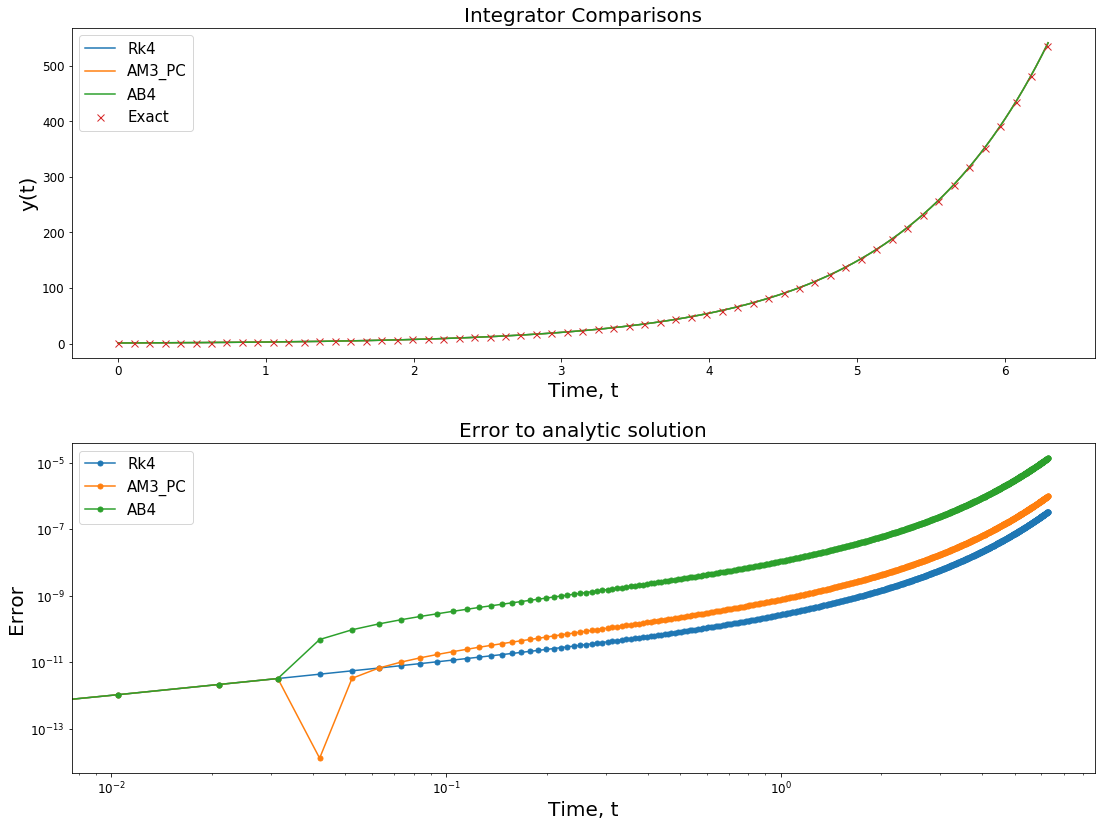

In [10]:
# solve given problem and compare solutions

# equations to be solved
def func2(t, y):
    return y
def func2_exact(t, y0):
    return y0*np.exp(t)

# set up
y0 = 1.
dt, t_max = 2*np.pi/600, 2*np.pi

# solve
time1, sol1 = RK4_alpha(func2, [y0], 0., t_max, dt)
time3, sol3 = AM3_PC(func2, [y0], 0., t_max, dt)
time4, sol4 = AB4(func2, [y0], 0., t_max, dt)
exact = func2_exact(time1, y0)

# plot
fig, ax = plt.subplots(2, 1, figsize=[15, 11])
fig.tight_layout(h_pad=6)

ax[0].plot(time1, sol1, '-', label=r'Rk4')
ax[0].plot(time3, sol3, '-', label=r'AM3_PC')
ax[0].plot(time4, sol4, '-', label=r'AB4')
ax[0].plot(time1[::10], exact[::10], 'x', label=r'Exact')

ax[1].loglog(time1, abs(exact-sol1.flatten()),
             'o-', label=r'Rk4', ms=5)
ax[1].loglog(time1, abs(exact-sol3.flatten()),
             'o-', label=r'AM3_PC', ms=5)
ax[1].loglog(time1, abs(exact-sol4.flatten()),
             'o-', label=r'AB4', ms=5)

ax[0].legend()
ax[1].legend()
ax[0].set(title=r'Integrator Comparisons', xlabel='Time, t', ylabel='y(t)')
ax[1].set(title='Error to analytic solution', xlabel='Time, t', ylabel='Error')

The previously mentioned issue of final evaluation is addressed by choosing dt such that it is a multiple of $t_{max}= 2\pi$, however as $2\pi$ is irrational there is a minor discrepancy between the final evaluation time and $t_{max}$ due to machine precision. This is accounted for by evaluating the exact solution for the purposes of errors at the final time evaluation rather than $2\pi$, though the impact this actually has on the results error analysis here is practically negligible. The dt value here is roughly 0.01.

In the first few steps all methods have the same error as each is using RK4. After this they differentiate, with RK4 seeming the best. There is odd behavior of AM3_PC during early time steps, possibly a burn-in affect due to its complex nature and the previous points originating from a different method with different error terms (though with the same order error). 

We now will find their convergence orders:

[Text(0,0.5,'Error'),
 Text(0.5,0,'Time, t'),
 Text(0.5,1,'Adams Methods Convergence')]

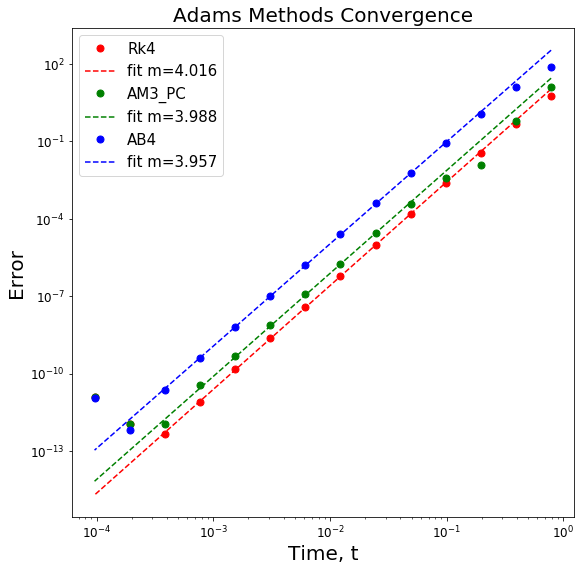

In [11]:
# setup
y0 = 1.
t_max = 2*np.pi
n_values = [2**n for n in range(3, 17)]
dts = 2 * np.pi / np.array(n_values)
errors = np.zeros([dts.size, 3])

# solve 
for n, dt in enumerate(dts):
    time1, sol1 = RK4_alpha(func2, [y0], 0., t_max, dt)
    time2, sol2 = AM3_PC(func2, [y0], 0., t_max, dt)
    time3, sol3 = AB4(func2, [y0], 0., t_max, dt)
    exact1 = func2_exact(time1[-1], y0)  # use the final time evalution for the exact solution
    exact2 = func2_exact(time2[-1], y0)
    exact3 = func2_exact(time3[-1], y0)
    errors[n] = [abs(exact1 - sol1[-1]),
                 abs(exact2 - sol2[-1]),
                 abs(exact3 - sol3[-1])]

# calculate lines of fit
log_errors = np.log10(errors)
log_dts = np.log10(dts)
params1 = np.polyfit(log_dts[2:-2], log_errors[2:-2, 0], 1)  # remove the high dt values from the fit and
params2 = np.polyfit(log_dts[4:-2], log_errors[4:-2, 1], 1)  # remove the low values where machine precision dominates
params3 = np.polyfit(log_dts[2:-2], log_errors[2:-2, 2], 1)

# plot errors
fig, ax = plt.subplots(figsize=[9, 9])
de_log = lambda x, c0, c1 : 10**(x*c0 + c1)
ax.loglog(dts, errors[:, 0], 'ro', label=r'Rk4')
ax.loglog(dts, de_log(log_dts, *params1), 'r--', label=r'fit m=%.3f' % params1[0])
ax.loglog(dts, errors[:, 1], 'go', label=r'AM3_PC')
ax.loglog(dts, de_log(log_dts, *params2), 'g--', label=r'fit m=%.3f' % params2[0])
ax.loglog(dts, errors[:, 2], 'bo', label=r'AB4')
ax.loglog(dts, de_log(log_dts, *params3), 'b--', label=r'fit m=%.3f' % params3[0])
ax.legend()
ax.set(title='Adams Methods Convergence', xlabel='Time, t', ylabel='Error')

Unlike before we have not only had to exclude the large $dt$ values in the linear fit but also the small ones as machine precision becomes a limiting factor and actually causes higher errors to accumulate by some mechanism within the codes implementation. There is also  unusual behavior for AM3_PC at $dt\sim 10^{-1}$ which was removed for a reasonable fit line. The cause of this discrepancy is not clear however the method is relatively complex and so this is likely a result of the exact behavior with regard to the problem we are solving. It is also worth noting that error orders are only the upper bound of the absolute error, which could be anything below this, though it is likely to be more or less Gaussian distributed so would rarely significant enough to be visible in log space (where orders of magnitude are observed).

Each method is seen to be 4th order accurate, as expected from there relative error analysis (not shown here). It is also clear that AB4 > AM3_PC > RK4 in terms of absolute error (with the exception of AM3 at $dt\sim 10^{-1}$). This is an expected trade off with function evaluations as AB4 takes only a single derivative evaluation at every time step, where as AM3_PC takes two and RK4 takes four. 

We could inspect the ratio of these errors either directly by taking the average ratio in the linear region. Alternatively we could compare the 0th order term fitted to the error orders in log space above. Both are used here: 

In [12]:
# calculate fractional errors thorugh mean values
frac_errors = errors[4:-2].copy() # remove_outliers
for i,n in enumerate(frac_errors[:, 2]):  # normaise by AB4 to find fractional errors
    frac_errors[i] /= n

ratio1 = frac_errors[:, 0].mean()
ratio2 = frac_errors[:, 1].mean()
print('\nVia calculating the mean of fractions in the linear region')
print('RK4    / AB4 = ', ratio1)
print('AM3_PC / AB4 = ', ratio2)

# calculate fractional errors thorugh fitted values
print('\nVia the linear fits in log space')
print('RK4    / AB4 = ', 10**params1[1] / 10**params3[1])
print('AM3_PC / AB4 = ', 10**params2[1] / 10**params3[1])


Via calculating the mean of fractions in the linear region
RK4    / AB4 =  0.023082675962614818
AM3_PC / AB4 =  0.06961568635765586

Via the linear fits in log space
RK4    / AB4 =  0.03176259575454021
AM3_PC / AB4 =  0.08306263283764864


Both methods give similar values which roughly agree with the differences between the two lines in the previous plot. The discrepancy between the two methods calculated ratios is because the second one assumes the orders (i.e. gradients) are all identical, so only needs to compute with the other fitted value.

To have estimated these errors by analytically we could have taken the general form for Adam's methods seen in lectures:
$$\sum_{j=0}^k \alpha_j \, y_{n+j} = \Delta t \sum_{j=0}^k \beta_j \, f(t_{n+j},y_{n+j}),$$
Where $\alpha s$ are the constants for the linear addition of the previous $k$ points and $\beta s$ are for the linear addition of the derivatives ($\beta_k \neq 0$ for addition of the derivative for the point we are finding i.e. implicit scheme). 
If we rearrange to make the RHS equal zero we can define the RHS to be the truncation error by subbing in a Taylor series $\widetilde y$ to each $y$ term on the left hand and see what remains:
$$\frac{1}{\Delta t}\left[ \sum_{j=0}^k \alpha_j \, \widetilde y(t_{n+j}) - \Delta t \sum_{j=0}^k \beta_j \, f(t_{n+j})\right] = \tau$$
Following through with this, using the constants from our two methods would give us a truncation error term for both methods which we could use to find the ratios. This is some involved maths so will not be done here.

## Coursework 1D - Implementing backward Euler using a nonlinear system solver

Here we are solving for a simple planetary orbit with the equation:

\begin{align*}
\dot{x} & = -y, \\[5pt] 
\dot{y} & = x
\end{align*} 

with initial conditions $x(0)=1,\; y(0)=0$. We know this to have an exact solution of a stable circular orbit.

### Implement the backward Euler scheme

Using the previous forward Euler method from in 1A we know the solution expands outwards due to the forward Euler tendency to under-estimate change in any step (either undershoots an increasing function or overshoots a decreasing one). A backwards Euler scheme we would expect to overestimate change therefore spiral inwards on this problem, this is verified by the implementation below: 



[Text(0,0.5,'y(t)'),
 Text(0.5,0,'x(t)'),
 Text(0.5,1,'Forward Backward Euler Comparison')]

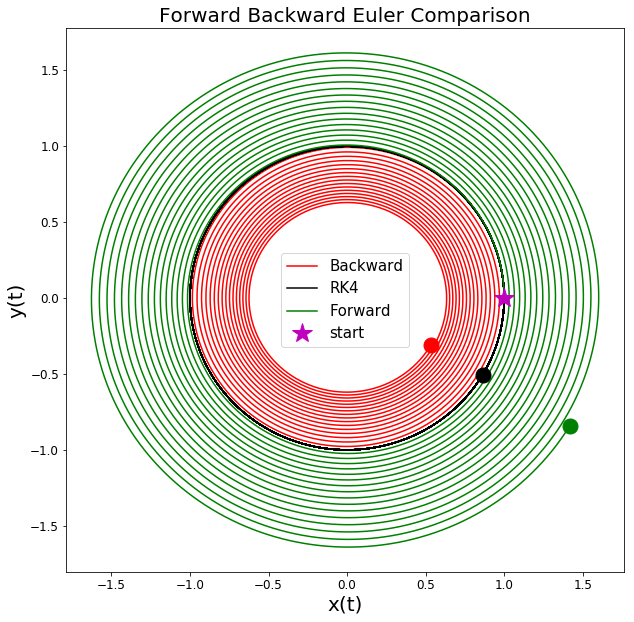

In [13]:
# solve & compare Euler forwards, backwards, rk4 (for comparison)

# equation to solve
def func3(t, array):
    x, y = array
    return np.array([-y, x])

# set up
y0 = np.array([1, 0])
dt, t_max = 0.01, 100

# solve with each method
time1, sol1 = Euler_Backward(func3, y0, 0., t_max, dt)
time2, sol2 = RK4_alpha(func3, y0, 0., t_max, dt)
time3, sol3 = Euler_Forwards(func3, y0, 0., t_max, dt)

# plot
fig, ax = plt.subplots(figsize=[10, 10])
ax.plot(sol1[:, 0], sol1[:, 1], 'r-', label=r'Backward')
ax.plot(sol2[:, 0], sol2[:, 1], 'k-', label=r'RK4')
ax.plot(sol3[:, 0], sol3[:, 1], 'g-', label=r'Forward')
ax.plot(y0[0], y0[1], 'm*', ms=20, label=r'start')  # plot start position
ax.legend()
ax.plot(sol1[-1, 0], sol1[-1, 1], 'ro', ms=15)  # plot the final positions
ax.plot(sol2[-1, 0], sol2[-1, 1], 'ko', ms=15)
ax.plot(sol3[-1, 0], sol3[-1, 1], 'go', ms=15)
ax.set(title=r'Forward Backward Euler Comparison', ylabel='y(t)', xlabel='x(t)')

The backward Euler method uses the fixed point method to solve the non-linear equation. Though this is a simple and not very stable method it proves sufficient for this problem (i.e. the gradient magnitude of the update function g is less than 1 for this problem).

Here we solve for $t_{max}=100$ and $dt=0.01$ and an RK4 solution is also plotted as a reference solution. 
We see the Backwards Euler over-estimates the change at each step causing an inwards spiral. The surprising observation is that the final points (noted by the dots) are all at the same angle from the origin. Though this may seem to break physics if one considers a planetary orbit, if we instead analyze the equations we are solving we see that this must be a feature.

<img src="./figs/orbit_maths.png" width=650px>

Hence at any radius the orbit period should be the same, so even though the radius is moving slightly due to errors in the numerical scheme, the ending angle is the same for each method.

###  Another implicit two-level scheme

Since the two methods are consistently under and over estimations it makes sense that the average of the two should be a better solution. This is the Trapezoidal method and is strait forward to solve given the previous integrators.

[Text(0,0.5,'y(t)'), Text(0.5,0,'x(t)'), Text(0.5,1,'Trapezodial Method')]

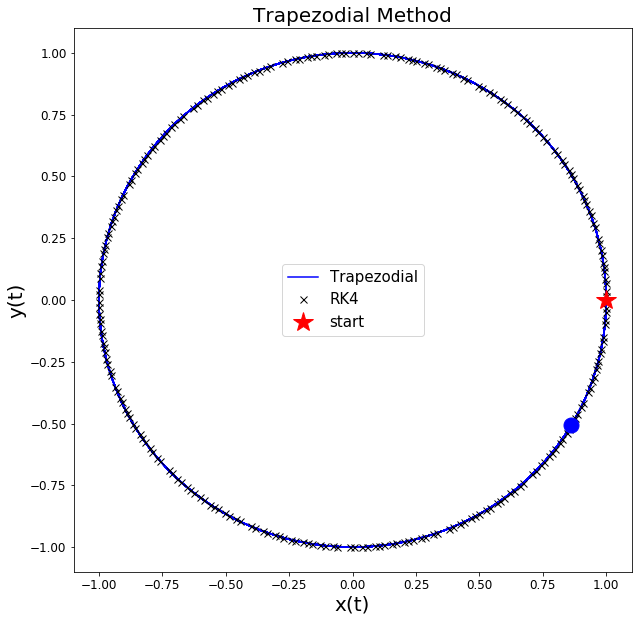

In [14]:
# solve Trapezodial (for comparison)

# set up
y0 = np.array([1, 0])
dt, t_max = 0.01, 100

# solve with each method
time1, sol1 = Trapezodial(func3, y0, 0., t_max, dt, atol=1e-8)
time2, sol2 = RK4_alpha(func3, y0, 0., t_max, dt)

# plot
fig, ax = plt.subplots(figsize=[10, 10])
ax.plot(sol1[:, 0], sol1[:, 1], 'b-', label=r'Trapezodial')
ax.plot(sol2[:, 0][::40], sol2[:, 1][::40], 'kx', label=r'RK4')
ax.plot(y0[0], y0[1], 'r*', ms=20, label=r'start')  # plot start position
ax.legend()
ax.plot(sol1[-1, 0], sol1[-1, 1], 'bo', ms=15)  # plot the final positions
ax.set(title=r'Trapezodial Method', ylabel='y(t)', xlabel='x(t)')

Observationally this is far better, but we should quantify this. Note the ending point is at roughly the same angle again, so we have another small validation here.

### Conservation law

As previously shown:

\begin{align*}
\frac{dr}{dt}=0 \qquad
\therefore \qquad r(t) = r(0)
\end{align*}

Hence we should be able to use the conversion of radius as a check of how well our integrators are working.

[Text(561.545,0.5,'y(t)'),
 Text(0.5,48,'x(t)'),
 Text(0.5,1,'Radius Time Development')]

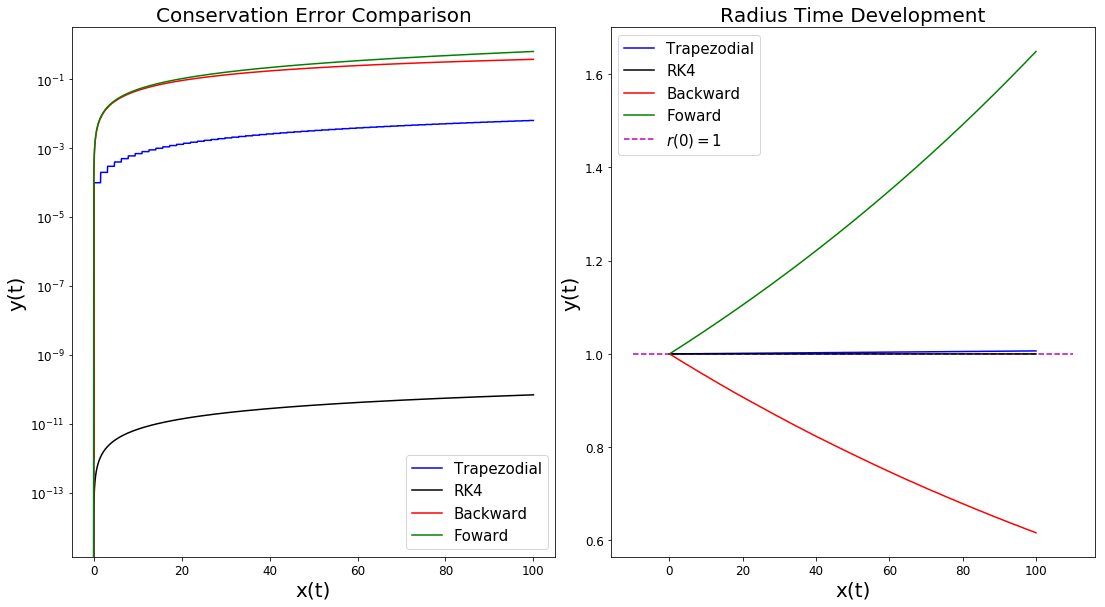

In [15]:
# solve Trapezodial (for comparison)

# set up
y0 = np.array([1, 0])
dt, t_max = 0.01, 100

# solve with each method
time1, sol1 = Trapezodial(func3, y0, 0., t_max, dt)
time2, sol2 = RK4_alpha(func3, y0, 0., t_max, dt)
time3, sol3 = Euler_Backward(func3, y0, 0., t_max, dt)
time4, sol4 = Euler_Forwards(func3, y0, 0., t_max, dt)

# find the r values
r1 = np.sqrt((sol1**2).sum(axis=1))
r2 = np.sqrt((sol2**2).sum(axis=1))
r3 = np.sqrt((sol3**2).sum(axis=1))
r4 = np.sqrt((sol4**2).sum(axis=1))

exact = np.sqrt((sol1[0]**2).sum())
# exact = 0

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 8])
fig.tight_layout(w_pad=2)

ax1.semilogy(time1, abs(r1 - exact), 'b-', label=r'Trapezodial')
ax1.semilogy(time2, abs(r2 - exact), 'k-', label=r'RK4')
ax1.semilogy(time3, abs(r3 - exact), 'r-', label=r'Backward')
ax1.semilogy(time4, abs(r4 - exact), 'g-', ms=20, label=r'Foward')
ax1.legend()
ax1.set(title=r'Conservation Error Comparison', ylabel='y(t)', xlabel='x(t)')

ax2.plot(time1, r1, 'b-', label=r'Trapezodial')
ax2.plot(time2, r2, 'k-', label=r'RK4')
ax2.plot(time3, r3, 'r-', label=r'Backward')
ax2.plot(time4, r4, 'g-', ms=20, label=r'Foward')
ax2.hlines(1, -10, 110, color='m', linestyle='--', label=r'$r(0)=1$')
ax2.legend()
ax2.set(title=r'Radius Time Development', ylabel='y(t)', xlabel='x(t)')

As can be seen the trapezoidal is $\sim 10^2$ times better than either forward or backward (which deviate equally from the conversion law), proving that trapezoidal is better as we previously observed.
We would expect trapezoidal to be around $10^2$ better than forward/backwards Euler as it is an $\mathcal{O}(dt^2)$ method, where as forward/backward Euler as both $\mathcal{O}(dt)$ methods and we have $dt=10^{-2}$. Under similar reasoning we expect RK4 to be at least $10^4$ times better than trapezoidal as we know RK4 to be a $\mathcal{O}(dt^4)$ method, however here it is $\sim10^8$ better, which is much larger. The greater improvement may be explained due to constant in the error proportionality or symmetries specific to this exact problem canceling the leading error terms.